# Retail Sales Forecasting - 3 of 5

## Tree-based algorithms - XGBoost

XGBoost is one of the more popular tree-based machine learning algorithms. Let's see how it performs on this relatively small data set.  

### Notebook Setup

In [14]:
%matplotlib inline

from __future__ import division
from __future__ import print_function

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# Import Pandas, Matplotlib, etc
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf

# Homegrown utilities for making lags, back testing, etc.
from lag_transformer import LagTransformer
from lag_cleaner import LagCleaner
from back_test import walk_forward_validate, calc_metrics, get_first_sunday, TimeSeriesFixedTestSplit

plt.style.use('ggplot')

### Load Sales Data

In [15]:
df_in = pd.read_excel('../data/daily-sales.xlsx', index_col='date', parse_dates=True)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2017-11-17 to 2018-11-03
Data columns (total 9 columns):
year          352 non-null int64
month         352 non-null object
week          352 non-null int64
day           352 non-null object
is_open       352 non-null int64
is_holiday    352 non-null int64
sales         352 non-null float64
customers     352 non-null int64
avg_sale      352 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 27.5+ KB


### Get Dummies

In [16]:
# Convert days into binary flags and drop the month
df_sales = df_in.drop(['year', 'month', 'week', 'customers', 'avg_sale'], axis='columns')
df_sales = pd.get_dummies(df_sales)

df_sales.head()

,is_open,is_holiday,sales,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
date,,,,,,,,,,
2017-11-17,1,0,348.63,1,0,0,0,0,0,0
2017-11-18,1,0,1334.38,0,0,1,0,0,0,0
2017-11-19,0,0,0.00,0,0,0,1,0,0,0
2017-11-20,1,0,512.08,0,1,0,0,0,0,0
2017-11-21,1,0,0.00,0,0,0,0,0,1,0


In [17]:
df_sales['sales'].describe()

count     352.000000
mean      711.925966
std       631.413817
min         0.000000
25%       237.855000
50%       559.600000
75%      1062.192500
max      3493.050000
Name: sales, dtype: float64

### Make Lags & Merge with the Dummy Day Features

In [18]:
y_col = 'sales'
x_cols = ['sales']
lags = [7, 28]

trans = LagTransformer(x_cols=x_cols, y_col=y_col, lags=lags)
df_lag = trans.transform(df_in)

# Clean the lagged data to remove the cases where sales from a closed
# day are being used to forecast an open day or vice-versa.
clean = LagCleaner()
df_lag = clean.fit_transform(df_lag)

df = pd.concat([df_lag, df_sales], axis='columns')
df.drop(['sales'], axis='columns', inplace=True)
df.dropna(inplace=True)

# Trim off the first few rows so we start on a Sunday
start_idx = get_first_sunday(df)
if start_idx > 0:
    df.drop(df.index[:start_idx], inplace=True)

df.tail(10)

,sales_t-28,sales_t-7,y,is_open,is_holiday,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
date,,,,,,,,,,,,
2018-10-25,608.01,956.26,1112.78,1,0,0,0,0,0,1,0,0
2018-10-26,1103.97,1337.40,1541.65,1,0,1,0,0,0,0,0,0
2018-10-27,2488.69,1102.00,1089.23,1,0,0,0,1,0,0,0,0
2018-10-28,0.00,0.00,0.00,0,0,0,0,0,1,0,0,0
2018-10-29,405.25,1381.53,832.45,1,0,0,1,0,0,0,0,0
2018-10-30,812.18,311.15,359.20,1,0,0,0,0,0,0,1,0
2018-10-31,636.13,1602.64,1252.43,1,0,0,0,0,0,0,0,1
2018-11-01,558.15,1112.78,656.54,1,0,0,0,0,0,1,0,0
2018-11-02,1070.58,1541.65,1097.56,1,0,1,0,0,0,0,0,0


### Back Test XGBoost

In [19]:
fixed_params = {
    'objective': 'reg:linear',
    'random_state': 0
}

model = xgb.XGBRegressor(**fixed_params)

df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 22.65%
RMSE for 30 week steps = 517.04


### Visualize Forecast vs Actual Sales

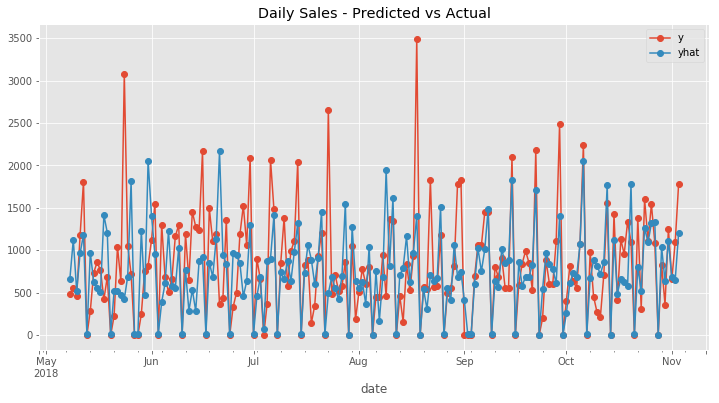

In [20]:
df_fcst = df_pred[['y', 'yhat']][-180:]
df_fcst.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual')
plt.show()

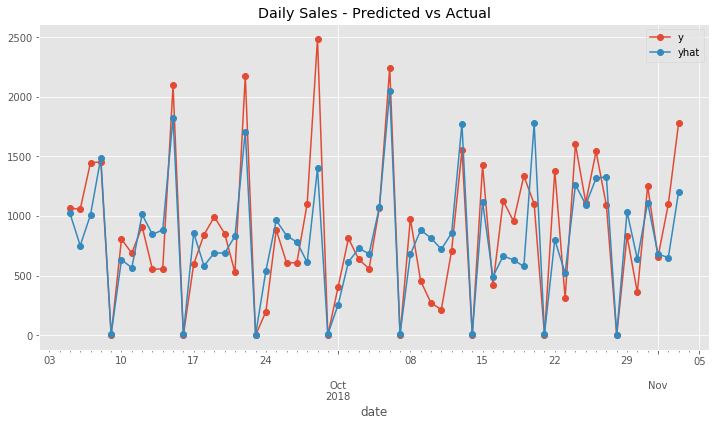

In [21]:
latest_df = df_pred[['y', 'yhat']][-60:]
latest_df.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual')
plt.show()

In [22]:
df_m.tail(12)

,MAPE,RMSE
date,,
2018-08-12,11.470604,840.189605
2018-08-19,16.705660,455.202495
2018-08-26,29.078593,613.295291
2018-09-02,14.182111,205.851379
2018-09-09,2.866206,213.994219
2018-09-16,10.402901,284.706343
2018-09-23,12.811714,483.372749
2018-09-30,5.536226,133.647905
2018-10-07,37.259792,357.864550


### Most Important Features

One of the handy things about tree-based algorithms like XGBoost is that it's easy to see which features led to the most splits and are considered most important.

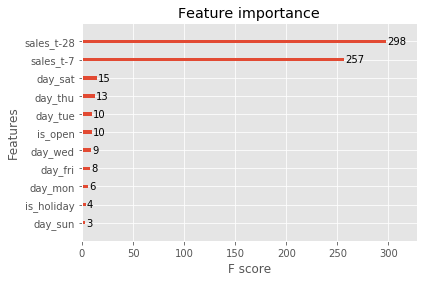

In [23]:
# Plot the feature importance
xgb.plot_importance(model)
plt.show()

### Hyper Parameter Tuning

XGBoost has a wealth of tunable hyper parameters. Try tuning a few of the more important ones like max_depth and n_estimators to get see if we can get better performance. 

**Note:**

Know that running the grid search below will take a few minutes so be patient after you hit 'run'.  You'll see a message from XGBoost when the grid search is finished.

In [24]:
X = df.drop('y', axis='columns')
y = df[['y']]

ts_split = TimeSeriesFixedTestSplit(len(X.index))

param_grid = {
    'max_depth': [1, 2, 5],
    'colsample_bytree': [0.1, 0.5, 0.8, 1.0],
    'min_child_weight': [2, 3, 4],
    'n_estimators': [20, 50, 75, 100]
}

model = xgb.XGBRegressor(model, random_state=0)

ts_cv = GridSearchCV(model, param_grid, n_jobs=10, cv=ts_split, scoring='neg_mean_squared_error', verbose=1)
ts_cv.fit(X, y)
rmse = sqrt(ts_cv.best_score_ * -1.0)
best = ts_cv.best_params_

print('Best params: {}'.format(best))
print('Best score: {}'.format(rmse))

Fitting 30 folds for each of 144 candidates, totalling 4320 fits


[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 2260 tasks      | elapsed:    6.0s


Best params: {'colsample_bytree': 0.5, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 50}
Best score: 517.0485281871812


[Parallel(n_jobs=10)]: Done 4320 out of 4320 | elapsed:   12.0s finished


In [25]:
# Re-test with optimized prarams
model = xgb.XGBRegressor(**fixed_params, **best)

df_pred2 = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred2)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

df_m.tail(12)

MAPE for 30 week steps = 19.70%
RMSE for 30 week steps = 468.21


,MAPE,RMSE
date,,
2018-08-12,22.395135,871.150228
2018-08-19,8.093858,441.572352
2018-08-26,25.815399,633.894774
2018-09-02,15.363907,203.499550
2018-09-09,1.173582,345.295364
2018-09-16,10.984665,339.552863
2018-09-23,6.484846,482.192784
2018-09-30,9.493676,298.030618
2018-10-07,26.012539,329.224027


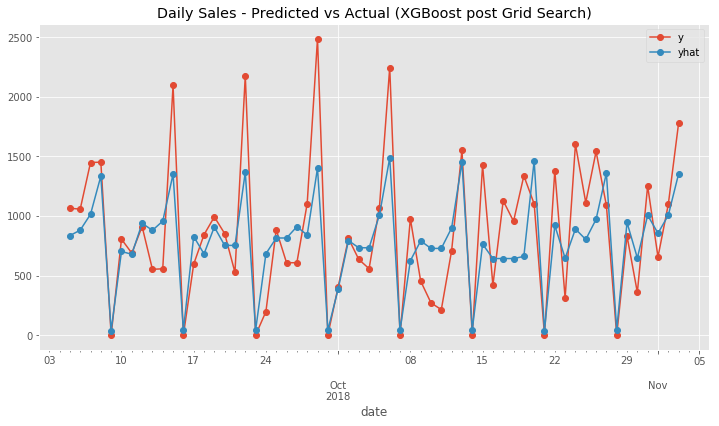

In [26]:
latest_df = df_pred2[['y', 'yhat']][-60:]
latest_df.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (XGBoost post Grid Search)')
plt.show()

### Conclusion

To recap, here's the baseline score

And here's the score from Elastic Net

XGBoost didn't perform quite as well on this small data set and was more difficult to tune. It did, however, provide really useful insight into what features were most important.